# Collaboration and Competition

---

Congratulations for completing the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control agents in a more challenging environment, where the goal is to train a team of agents to play soccer.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The **actor network** receives his own state space and outputs an action, the log probability of that action (to be used later in calculating the advantage ratio) and the entropy of the probability distribution. Higher entropy indicates more uncertainty in the probabilities. For example, when the probability of the goalie choosing 1 of the 4 possible actions is roughly equal (25% each), this would be maximum entropy. When one of those actions has 100% probability and the other 3 actions have 0% probability, the agent is absolutely certain and entropy will be zero. **Action space for this environment is categorical, not continuous**. 

We use **entropy as noise** in the loss function to force the agent to try more random actions early on and not get fixated on a solution which is not optimal in the long run (stuck in a local minima.). Since we are performing gradient descent on the negative of entropy, we are maximizing it. However, the decaying beta value will continuously shrink the contribution of entropy in the loss function, leading to more optimization to minimize policy and value loss. Hence, we will notice a dip in entropy with entropy with time as the agent's policy and critic nets becomes increasingly confident of their predictions.

The **critic network** receives the combined state space of all 4 agents on the field and outputs the expected average value (total reward) for an action taken given that state. It learns in a supervised learning fashion by optimizing the MSE loss between future cumulative reward vs state-value estimation. State-value estimates converges with sufficient exploration. 

The **advantage function** is used in computing policy loss to indicate how much better an agent is performing relative to a baseline. This baseline is the state-value prediction from the critic network on how much rewards an agent ought to receive given a state. Hence, as an agent improves (make better actions and more accurately predict value of states), it is forced to make even better actions that yield higher rewards than what is thought to be the 'averaged' reward for being in that particular state. In simple terms, an R=+30 may be good at the start, but not as desirable in later training phases. Here, we use **either A3C or GAE Value Estimation**. 

**A note on the distributions function:**
It is not possible to have the actor simply output a softmax distribution of action probabilities and then choose an action  off a random sampling of those probabilities. Neural networks cannot directly backpropagate through random samples. PyTorch and Tensorflow offer a distribution function to solve this that makes the action selection differentiable. The actor passes the softmax output through this distribution function to select the action and then backpropagation can occur.
https://pytorch.org/docs/stable/distributions.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import pprint 
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from ppo_agent import PPO_Agent
from params import Params
from logger import Logger
from logger_team import Logger_Team
from CustomSummaryWriter import CustomSummaryWriter

In [8]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [4]:
## For Debugging (Might slow progress quite alot!)
#torch.autograd.set_detect_anomaly(True)
#np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [30]:
################################
# Compress tensorboard logfile
################################

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# event_file_path = "runs/Apr03_03-24-35_DESKTOP-4IJ7ORD/events.out.tfevents.1648927475.DESKTOP-4IJ7ORD.10476.10"
# writer=tf.summary.FileWriter(logdir="runs")
# for event in tf.train.summary_iterator(event_file_path):
#     event_type = event.WhichOneof('what')
#     if event_type != 'summary':
#         writer.add_event(event)
#     else:
#         wall_time = event.wall_time
#         step = event.step

#         # possible types: simple_value, image, histo, audio
#         filtered_values = [value for value in event.summary.value if value.HasField('simple_value')]
#         summary = tf.Summary(value=filtered_values)

#         filtered_event = tf.summary.Event(summary=summary,
#                                           wall_time=wall_time,
#                                           step=step)
#         writer.add_event(filtered_event)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Soccer.app"`
- **Windows** (x86): `"path/to/Soccer_Windows_x86/Soccer.exe"`
- **Windows** (x86_64): `"path/to/Soccer_Windows_x86_64/Soccer.exe"`
- **Linux** (x86): `"path/to/Soccer_Linux/Soccer.x86"`
- **Linux** (x86_64): `"path/to/Soccer_Linux/Soccer.x86_64"`
- **Linux** (x86, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86"`
- **Linux** (x86_64, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86_64"`

For instance, if you are using a Mac, then you downloaded `Soccer.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Soccer.app")
```

In [3]:
env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe')
#env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [4]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))
total_state_size = 2*g_state_size + 2*s_state_size

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
# for i in range(2):                                         # play game for 2 episodes
#     env_info = env.reset(train_mode=False)                 # reset the environment    
#     g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
#     s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
#     g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
#     s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
#     while True:
#         # select actions and send to environment
#         g_actions = np.random.randint(g_action_size, size=num_g_agents)
#         s_actions = np.random.randint(s_action_size, size=num_s_agents)
#         actions = dict(zip([g_brain_name, s_brain_name], 
#                            [g_actions, s_actions]))
#         env_info = env.step(actions)                       
        
#         # get next states
#         g_next_states = env_info[g_brain_name].vector_observations         
#         s_next_states = env_info[s_brain_name].vector_observations
        
#         # get reward and update scores
#         g_rewards = env_info[g_brain_name].rewards  
#         s_rewards = env_info[s_brain_name].rewards
#         g_scores += g_rewards
#         s_scores += s_rewards
        
#         # check if episode finished
#         done = np.any(env_info[g_brain_name].local_done)  
        
#         # roll over states to next time step
#         g_states = g_next_states
#         s_states = s_next_states
        
#         # exit loop if episode finished
#         if done:                                           
#             break
#     print('Scores from episode {}: {} (goalies), {} (strikers)'.format(i+1, g_scores, s_scores))

Scores from episode 1: [1.00166669 1.00166669] (goalies), [-1.00166669 -1.00166669] (strikers)
Scores from episode 2: [ 0.46833333 -0.63166678] (goalies), [ 0.63166678 -0.46833333] (strikers)


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

# Training against a Random Agent

In [11]:
def ppo(params=Params(), g_logger=Logger(), s_logger=Logger(), team_logger=Logger_Team()):
    
    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now()         
    env_info = env.reset(train_mode=True)
    g_logger.initialize(g_agent, g_state_size, g_action_size)
    s_logger.initialize(s_agent, s_state_size, s_action_size)
    step = 0

#     try:
    start_eps = params.eps_to_resume_from if not params.restart_training else 1        
    for i_episode in range(start_eps, params.n_episodes+1):
        env_info = env.reset(train_mode=True)                  # reset the environment
        g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
        s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)            
        g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
        s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
        num_steps = 0

        for t in range(params.max_t):    
            num_steps = t

            # Perform actions from each agent's policy network (clipped actions [0, -1])
            g_action, g_log_prob = g_agent.act(g_states[0])
            s_action, s_log_prob = s_agent.act(s_states[0])
            g_actions = (g_action, np.random.randint(g_action_size))
            s_actions = (s_action, np.random.randint(s_action_size))
            actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
            env_info = env.step(actions)                   

            # get next states, rewards & dones
            g_next_states = env_info[g_brain_name].vector_observations         
            s_next_states = env_info[s_brain_name].vector_observations
            g_rewards = env_info[g_brain_name].rewards  
            s_rewards = env_info[s_brain_name].rewards
            done = np.any(env_info[g_brain_name].local_done) 

            # Store in experience buffer & learn
            all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
            g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob, done)
            s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob, done)
            g_states = g_next_states
            s_states = s_next_states
            g_scores += g_rewards
            s_scores += s_rewards                

            # Break if game is over (time out / score)
            if done:   
                break 

        # Learn from episode (add last_all_state if using GAE)
        last_all_states = np.concatenate((s_next_states[0], s_next_states[1], g_next_states[0], g_next_states[1]))   
        g_agent.add_last_all_state(last_all_states)
        s_agent.add_last_all_state(last_all_states)
        g_agent.learn()
        s_agent.learn()

        # Print crucial results for progress tracking
        for i in range(len(g_agent.actor_losses)):
            step += 1
            g_logger.log_stats(step, g_scores[0], g_agent.actor_losses[i], g_agent.critic_losses[i], g_agent.entropy_losses[i])
            s_logger.log_stats(step, s_scores[0], s_agent.actor_losses[i], s_agent.critic_losses[i], s_agent.entropy_losses[i])
        g_logger.log_weights(i_episode)
        s_logger.log_weights(i_episode)
        team_logger.log_stats(i_episode, g_scores[0] + s_scores[0], g_scores[1] + s_scores[1])
        print('\rEpisode {}: \tNum Steps: {} \t G_score: {:.2f} \t S_Score: {:.2f}  \tWin: {} \t\t'.format(i_episode, num_steps, g_logger.scores_deque[-1], 
                                                        s_logger.scores_deque[-1], team_logger.wins_deque[-1]), end="")

        if i_episode % params.save_every == 0:
            s_logger.save_weights(i_episode)
            g_logger.save_weights(i_episode)

        if i_episode % params.print_every == 0:
            print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
                  .format(i_episode, team_logger.scores_cum_deque[-1], team_logger.scores_opp_cum_deque[-1], np.count_nonzero(team_logger.wins_deque), 
                          np.count_nonzero(team_logger.lose_deque), np.count_nonzero(team_logger.draws_deque), len(team_logger.wins_deque)))

            if team_logger.scores_cum_deque[-1] >= params.target_score:
                print('\nEnvironment solved in {:d} episodes!\tAvg Total Score: {:.2f} \tAvg Total Wins: {}/{}'
                      .format(i_episode, np.mean(team_logger.scores_deque), np.count_nonzero(team_logger.wins_deque), len(team_logger.wins_deque)))
                if params.terminate_on_target_score:
                    break

    # Plot graphs & save final weights
    g_logger.save_weights(i_episode)
    s_logger.save_weights(i_episode)
    if params.plot_stats:
        team_logger.plot_stats()
        g_logger.plot_stats()                       
        s_logger.plot_stats()
    team_logger.log_overall_perf_tb()
    total_train_duration(start_time=start_time, end_time=datetime.now())
    print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
#     # Catch any exceptions (Esp with keyboard interrupts)
#     except BaseException as error:
#         print('\n\n==== An exception occurred: {}'.format(error))
#         g_logger.save_weights(i_episode)
#         s_logger.save_weights(i_episode)
#         if params.plot_stats:
#             team_logger.plot_stats()
#             g_logger.plot_stats()                       
#             s_logger.plot_stats()
#         team_logger.log_overall_perf_tb()
#         total_train_duration(start_time=start_time, end_time=datetime.now())
#         print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return s_logger.scores_list


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0



In [15]:
##################
# QUICK TEST
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=10
params.max_t = 600
params.print_every = 2
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32

# Goalie Params
g_params = copy.deepcopy(params)
g_params.lr = 1e-4  
g_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/goalie_expt'
g_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/goalie_expt'

# Striker Params
s_params = copy.deepcopy(params)
s_params.lr = 8e-5  
s_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/striker_expt'
s_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/striker_expt'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(g_params, tb, "Goalie")
s_logger = Logger(s_params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


============ Goalie HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3)

KeyboardInterrupt: 


============ Goalie HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc

Episode 2900: 	Team Score: 38.50 	Opponent Score: -38.50 	 Win|Lose|Draw: 59|24|17 	 [Out of 100 Matches]
Episode 2920: 	Team Score: 35.20 	Opponent Score: -35.20 	 Win|Lose|Draw: 57|25|18 	 [Out of 100 Matches]
Episode 2940: 	Team Score: 33.00 	Opponent Score: -33.00 	 Win|Lose|Draw: 54|24|22 	 [Out of 100 Matches]
Episode 2960: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 55|22|23 	 [Out of 100 Matches]
Episode 2980: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 56|23|21 	 [Out of 100 Matches]
Episode 3000: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 55|22|23 	 [Out of 100 Matches]
Episode 3020: 	Team Score: 42.90 	Opponent Score: -42.90 	 Win|Lose|Draw: 56|17|27 	 [Out of 100 Matches]
Episode 3040: 	Team Score: 42.90 	Opponent Score: -42.90 	 Win|Lose|Draw: 58|19|23 	 [Out of 100 Matches]
Episode 3060: 	Team Score: 44.00 	Opponent Score: -44.00 	 Win|Lose|Draw: 57|17|26 	 [Out of 100 Matches]
Episode 3080: 	Team Score: 39.60 	Opponent Sco

Episode 5980: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 74|13|13 	 [Out of 100 Matches]
Episode 6000: 	Team Score: 73.70 	Opponent Score: -73.70 	 Win|Lose|Draw: 78|11|11 	 [Out of 100 Matches]
Episode 6020: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 72|11|17 	 [Out of 100 Matches]
Episode 6040: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 72|11|17 	 [Out of 100 Matches]
Episode 6060: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 77|7|16 	 [Out of 100 Matches]
Episode 6080: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 83|5|12 	 [Out of 100 Matches]
Episode 6100: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 81|6|13 	 [Out of 100 Matches]
Episode 6120: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 84|7|9 	 [Out of 100 Matches]
Episode 6140: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 85|7|8 	 [Out of 100 Matches]
Episode 6160: 	Team Score: 82.50 	Opponent Score: -82

Episode 9100: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 84|9|7 	 [Out of 100 Matches]
Episode 9120: 	Team Score: 78.10 	Opponent Score: -78.10 	 Win|Lose|Draw: 82|11|7 	 [Out of 100 Matches]
Episode 9140: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 81|12|7 	 [Out of 100 Matches]
Episode 9160: 	Team Score: 73.70 	Opponent Score: -73.70 	 Win|Lose|Draw: 80|13|7 	 [Out of 100 Matches]
Episode 9180: 	Team Score: 70.40 	Opponent Score: -70.40 	 Win|Lose|Draw: 79|15|6 	 [Out of 100 Matches]
Episode 9200: 	Team Score: 71.50 	Opponent Score: -71.50 	 Win|Lose|Draw: 80|15|5 	 [Out of 100 Matches]
Episode 9220: 	Team Score: 70.40 	Opponent Score: -70.40 	 Win|Lose|Draw: 79|15|6 	 [Out of 100 Matches]
Episode 9240: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 78|10|12 	 [Out of 100 Matches]
Episode 9260: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 83|7|10 	 [Out of 100 Matches]
Episode 9280: 	Team Score: 92.40 	Opponent Score: -92.4

Episode 12200: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 90|6|4 	 [Out of 100 Matches]
Episode 12220: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 90|6|4 	 [Out of 100 Matches]
Episode 12240: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 12260: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 94|3|3 	 [Out of 100 Matches]
Episode 12280: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 12300: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 91|5|4 	 [Out of 100 Matches]
Episode 12320: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 89|6|5 	 [Out of 100 Matches]
Episode 12340: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 88|7|5 	 [Out of 100 Matches]
Episode 12360: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 87|7|6 	 [Out of 100 Matches]
Episode 12380: 	Team Score: 86.90 	Opponent Score: -8

Episode 15280: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|2|15 	 [Out of 100 Matches]
Episode 15300: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 83|3|14 	 [Out of 100 Matches]
Episode 15320: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 82|4|14 	 [Out of 100 Matches]
Episode 15340: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|2|15 	 [Out of 100 Matches]
Episode 15360: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 84|2|14 	 [Out of 100 Matches]
Episode 15380: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|10 	 [Out of 100 Matches]
Episode 15400: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 90|3|7 	 [Out of 100 Matches]
Episode 15420: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 91|2|7 	 [Out of 100 Matches]
Episode 15440: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 92|3|5 	 [Out of 100 Matches]
Episode 15460: 	Team Score: 94.60 	Opponent Score

Episode 18360: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 76|6|18 	 [Out of 100 Matches]
Episode 18380: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 76|7|17 	 [Out of 100 Matches]
Episode 18400: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 75|7|18 	 [Out of 100 Matches]
Episode 18420: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 73|7|20 	 [Out of 100 Matches]
Episode 18440: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 76|7|17 	 [Out of 100 Matches]
Episode 18460: 	Team Score: 79.20 	Opponent Score: -79.20 	 Win|Lose|Draw: 77|5|18 	 [Out of 100 Matches]
Episode 18480: 	Team Score: 80.30 	Opponent Score: -80.30 	 Win|Lose|Draw: 78|5|17 	 [Out of 100 Matches]
Episode 18500: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 74|8|18 	 [Out of 100 Matches]
Episode 18520: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 72|10|18 	 [Out of 100 Matches]
Episode 18540: 	Team Score: 67.10 	Opponent S

Episode 21440: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 21460: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 90|5|5 	 [Out of 100 Matches]
Episode 21480: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 88|6|6 	 [Out of 100 Matches]
Episode 21500: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 85|5|10 	 [Out of 100 Matches]
Episode 21520: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 82|6|12 	 [Out of 100 Matches]
Episode 21540: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 84|3|13 	 [Out of 100 Matches]
Episode 21560: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 81|4|15 	 [Out of 100 Matches]
Episode 21580: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 85|2|13 	 [Out of 100 Matches]
Episode 21600: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 88|2|10 	 [Out of 100 Matches]
Episode 21620: 	Team Score: 95.70 	Opponent Score

Episode 24520: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 92|1|7 	 [Out of 100 Matches]
Episode 24540: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 92|1|7 	 [Out of 100 Matches]
Episode 24560: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 93|0|7 	 [Out of 100 Matches]
Episode 24580: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 94|0|6 	 [Out of 100 Matches]
Episode 24600: 	Team Score: 104.50 	Opponent Score: -104.50 	 Win|Lose|Draw: 96|1|3 	 [Out of 100 Matches]
Episode 24620: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 94|2|4 	 [Out of 100 Matches]
Episode 24640: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 93|2|5 	 [Out of 100 Matches]
Episode 24660: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 90|2|8 	 [Out of 100 Matches]
Episode 24680: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 90|2|8 	 [Out of 100 Matches]
Episode 24700: 	Team Score: 99.00 	Oppone

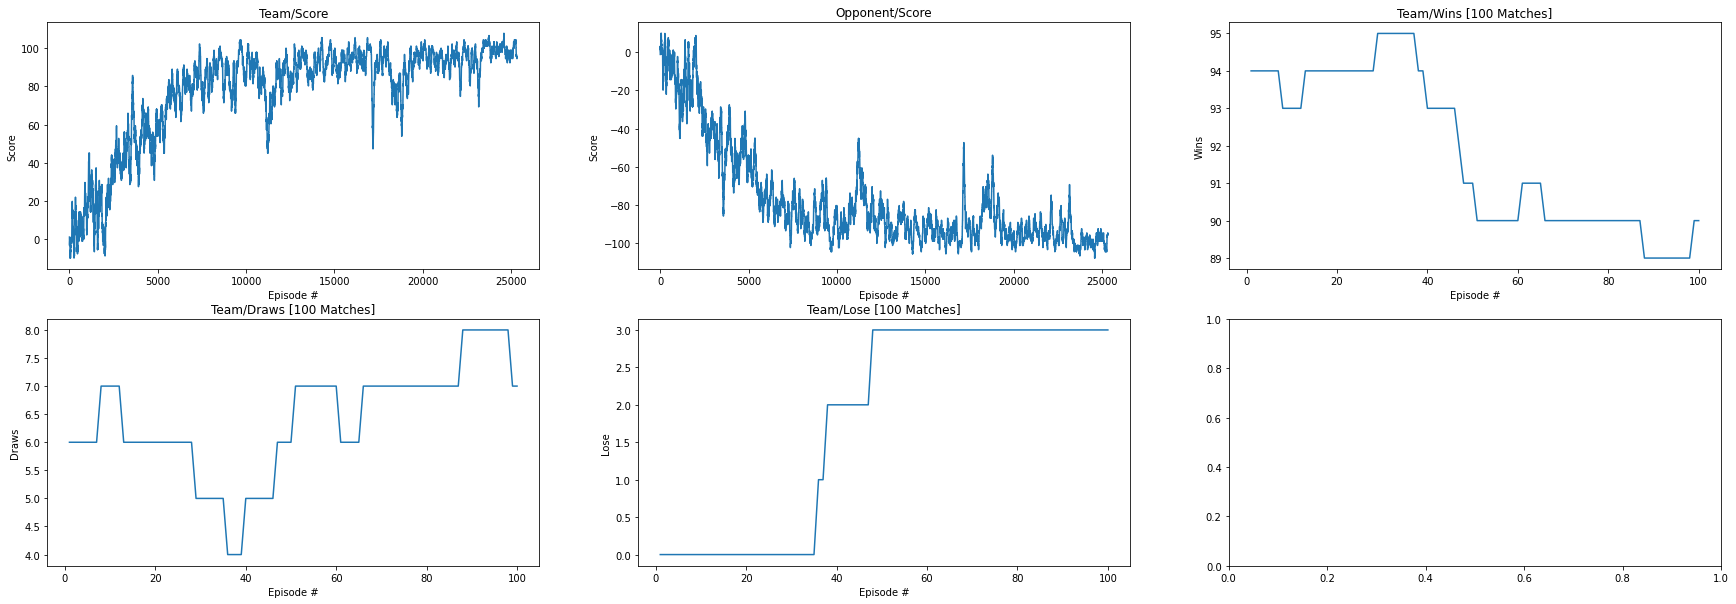

===== Goalie =====


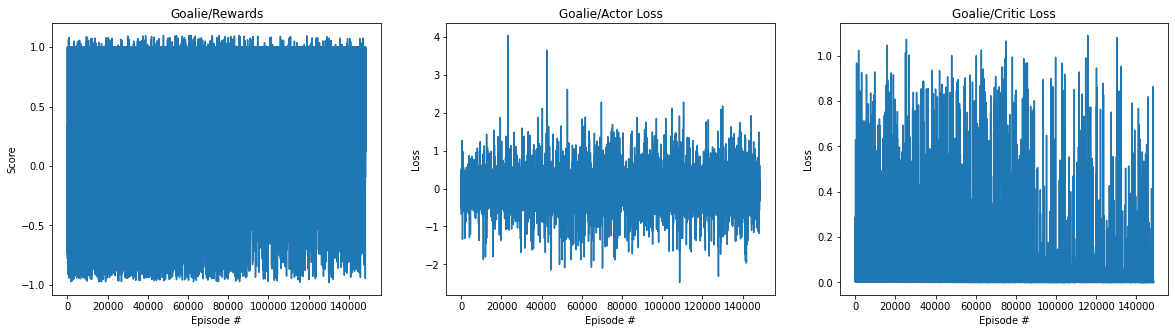

===== Striker =====


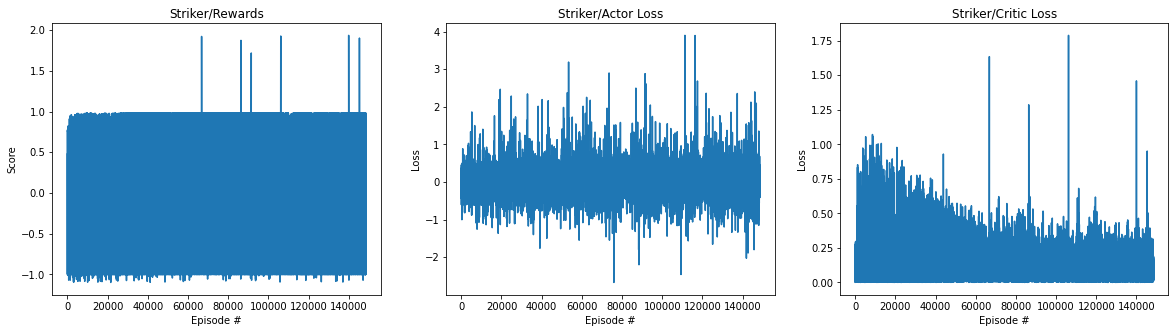

TOTAL TRAINING DURATION: 0 days, 12 hours, 46 minutes and 37 seconds
***TRAINING STOPPED AT 2022-04-02--10:44:55 


[0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1

In [13]:
##################
# EXPT with much longer entropy decay rate to encourage exploration
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=100000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32
params.beta_decay = 0.9975   # Instead of 0.995

# Goalie Params
g_params = copy.deepcopy(params)
g_params.lr = 8e-5  
g_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/goalie_run2'
g_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/goalie_run2'

# Striker Params
s_params = copy.deepcopy(params)
s_params.lr = 1e-4  
s_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/striker_run2'
s_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/striker_run2'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(g_params, tb, "Goalie")
s_logger = Logger(s_params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g_params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s_params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


===== Team =====


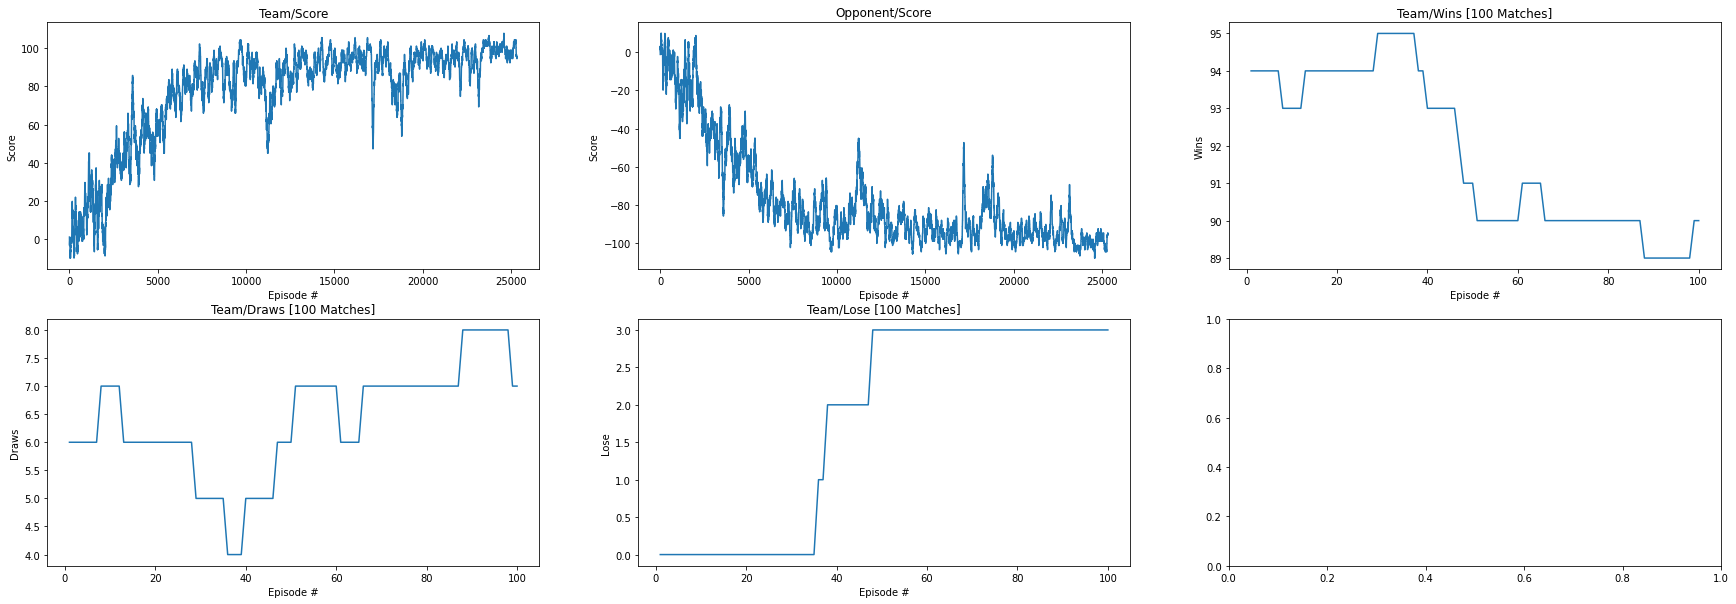

===== Goalie =====


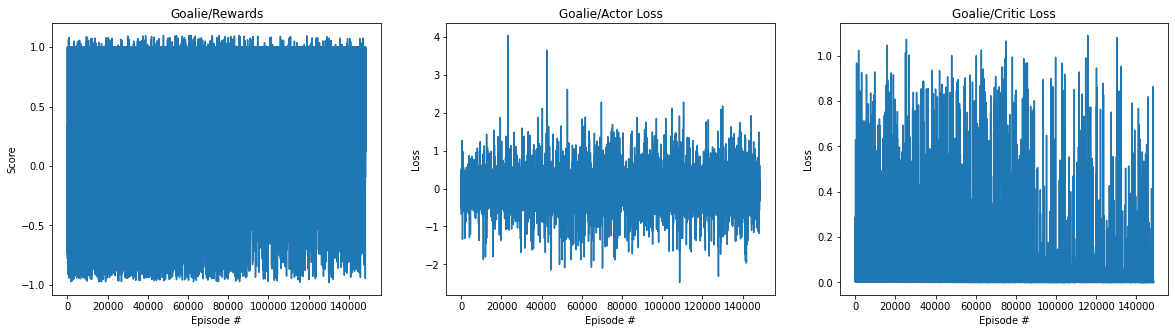

===== Striker =====


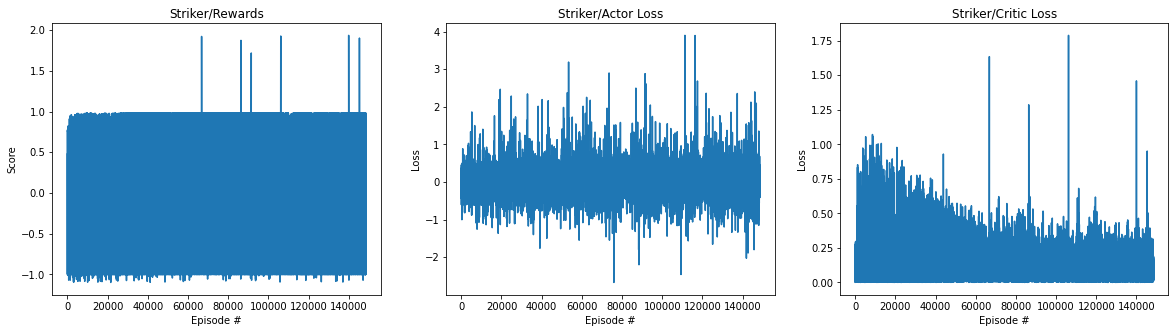

In [28]:
# Print Training Stats...
team_logger.plot_stats()
g_logger.plot_stats()                       
s_logger.plot_stats()


============ Goalie HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0
USE GAE:  True
GAE TAU:  0.99


============ Striker HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0
USE GAE:  True
GAE TAU:  0.99


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2)

Episode 2880: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 79|13|8 	 [Out of 100 Matches]
Episode 2900: 	Team Score: 70.40 	Opponent Score: -70.40 	 Win|Lose|Draw: 78|14|8 	 [Out of 100 Matches]
Episode 2920: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 77|16|7 	 [Out of 100 Matches]
Episode 2940: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 78|16|6 	 [Out of 100 Matches]
Episode 2960: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 78|16|6 	 [Out of 100 Matches]
Episode 2980: 	Team Score: 59.40 	Opponent Score: -59.40 	 Win|Lose|Draw: 74|20|6 	 [Out of 100 Matches]
Episode 3000: 	Team Score: 52.80 	Opponent Score: -52.80 	 Win|Lose|Draw: 70|22|8 	 [Out of 100 Matches]
Episode 3020: 	Team Score: 52.80 	Opponent Score: -52.80 	 Win|Lose|Draw: 70|22|8 	 [Out of 100 Matches]
Episode 3040: 	Team Score: 49.50 	Opponent Score: -49.50 	 Win|Lose|Draw: 67|22|11 	 [Out of 100 Matches]
Episode 3060: 	Team Score: 51.70 	Opponent Score: -51.

Episode 5980: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 84|10|6 	 [Out of 100 Matches]
Episode 6000: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 85|9|6 	 [Out of 100 Matches]
Episode 6020: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 86|8|6 	 [Out of 100 Matches]
Episode 6040: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 85|8|7 	 [Out of 100 Matches]
Episode 6060: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 86|8|6 	 [Out of 100 Matches]
Episode 6080: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 87|8|5 	 [Out of 100 Matches]
Episode 6100: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 89|7|4 	 [Out of 100 Matches]
Episode 6120: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 89|7|4 	 [Out of 100 Matches]
Episode 6140: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 93|5|2 	 [Out of 100 Matches]
Episode 6160: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|

Episode 7540: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 78|10|12 	 [Out of 100 Matches]
Episode 7560: 	Team Score: 80.30 	Opponent Score: -80.30 	 Win|Lose|Draw: 81|8|11 	 [Out of 100 Matches]
Episode 7580: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 79|11|10 	 [Out of 100 Matches]
Episode 7600: 	Team Score: 66.00 	Opponent Score: -66.00 	 Win|Lose|Draw: 74|14|12 	 [Out of 100 Matches]
Episode 7620: 	Team Score: 66.00 	Opponent Score: -66.00 	 Win|Lose|Draw: 76|16|8 	 [Out of 100 Matches]
Episode 7640: 	Team Score: 66.00 	Opponent Score: -66.00 	 Win|Lose|Draw: 77|17|6 	 [Out of 100 Matches]
Episode 7660: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 78|17|5 	 [Out of 100 Matches]
Episode 7680: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 77|16|7 	 [Out of 100 Matches]
Episode 7700: 	Team Score: 64.90 	Opponent Score: -64.90 	 Win|Lose|Draw: 76|17|7 	 [Out of 100 Matches]
Episode 7720: 	Team Score: 61.60 	Opponent Score: -6

Episode 9100: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 81|5|14 	 [Out of 100 Matches]
Episode 9120: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 79|5|16 	 [Out of 100 Matches]
Episode 9140: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 83|5|12 	 [Out of 100 Matches]
Episode 9160: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 83|4|13 	 [Out of 100 Matches]
Episode 9180: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 85|3|12 	 [Out of 100 Matches]
Episode 9200: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 84|2|14 	 [Out of 100 Matches]
Episode 9220: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 88|3|9 	 [Out of 100 Matches]
Episode 9240: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 87|4|9 	 [Out of 100 Matches]
Episode 9260: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 90|3|7 	 [Out of 100 Matches]
Episode 9280: 	Team Score: 93.50 	Opponent Score: -93.50 	

Episode 10660: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 94|2|4 	 [Out of 100 Matches]
Episode 10680: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 96|2|2 	 [Out of 100 Matches]
Episode 10700: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 96|2|2 	 [Out of 100 Matches]
Episode 10720: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 94|3|3 	 [Out of 100 Matches]
Episode 10740: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 96|2|2 	 [Out of 100 Matches]
Episode 10760: 	Team Score: 102.30 	Opponent Score: -102.30 	 Win|Lose|Draw: 95|2|3 	 [Out of 100 Matches]
Episode 10780: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 93|2|5 	 [Out of 100 Matches]
Episode 10800: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 89|3|8 	 [Out of 100 Matches]
Episode 10820: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 90|3|7 	 [Out of 100 Matches]
Episode 10840: 	Team Score: 90.20 	Oppone

Episode 13740: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 89|3|8 	 [Out of 100 Matches]
Episode 13760: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|10 	 [Out of 100 Matches]
Episode 13780: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 86|4|10 	 [Out of 100 Matches]
Episode 13800: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 82|7|11 	 [Out of 100 Matches]
Episode 13820: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 84|7|9 	 [Out of 100 Matches]
Episode 13840: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 84|10|6 	 [Out of 100 Matches]
Episode 13860: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 83|13|4 	 [Out of 100 Matches]
Episode 13880: 	Team Score: 73.70 	Opponent Score: -73.70 	 Win|Lose|Draw: 82|15|3 	 [Out of 100 Matches]
Episode 13900: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 86|12|2 	 [Out of 100 Matches]
Episode 13920: 	Team Score: 73.70 	Opponent Scor

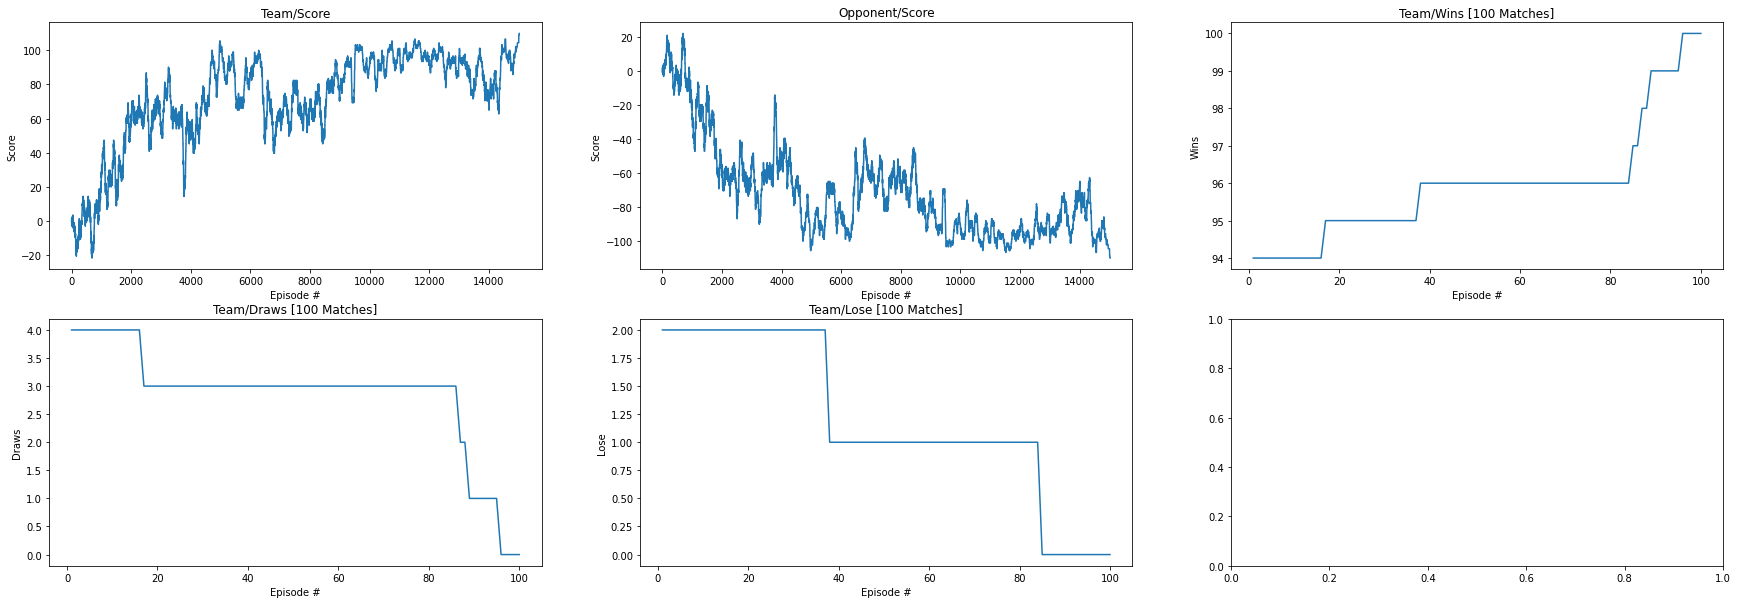

===== Goalie =====


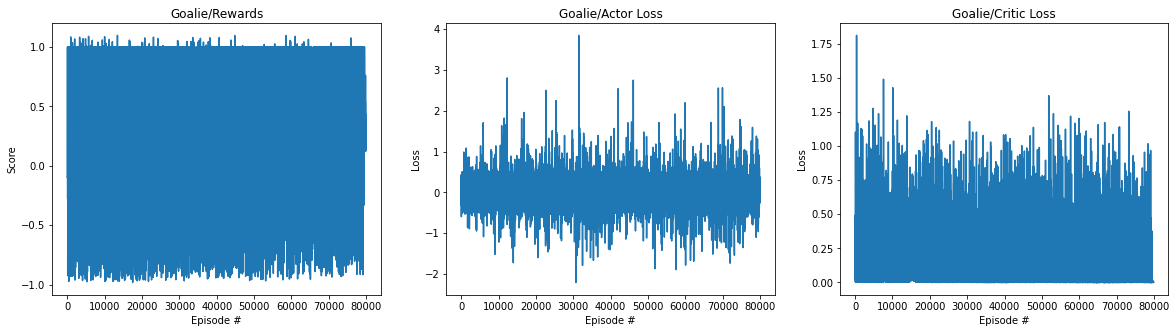

===== Striker =====


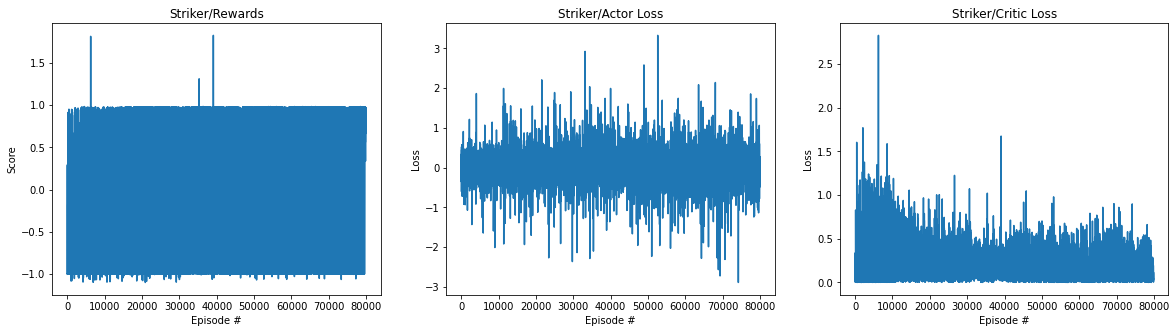

TOTAL TRAINING DURATION: 0 days, 6 hours, 51 minutes and 18 seconds
***TRAINING STOPPED AT 2022-04-03--10:15:53 


[-1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 -1.0033333476167172,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 0.29000004404224455,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1

In [16]:
##################
# EXPT with Generalized Advantage Estimation (GAE)
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=100000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32
params.beta_decay = 0.9975   # Instead of 0.995
params.use_gae = True
params.gae_tau = 0.99

# Goalie Params
g_params = copy.deepcopy(params)
g_params.lr = 8e-5  
g_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/goalie_run2'
g_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/goalie_run2'

# Striker Params
s_params = copy.deepcopy(params)
s_params.lr = 1e-4  
s_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/striker_run2'
s_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/striker_run2'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(g_params, tb, "Goalie")
s_logger = Logger(s_params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g_params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s_params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


===== Team =====


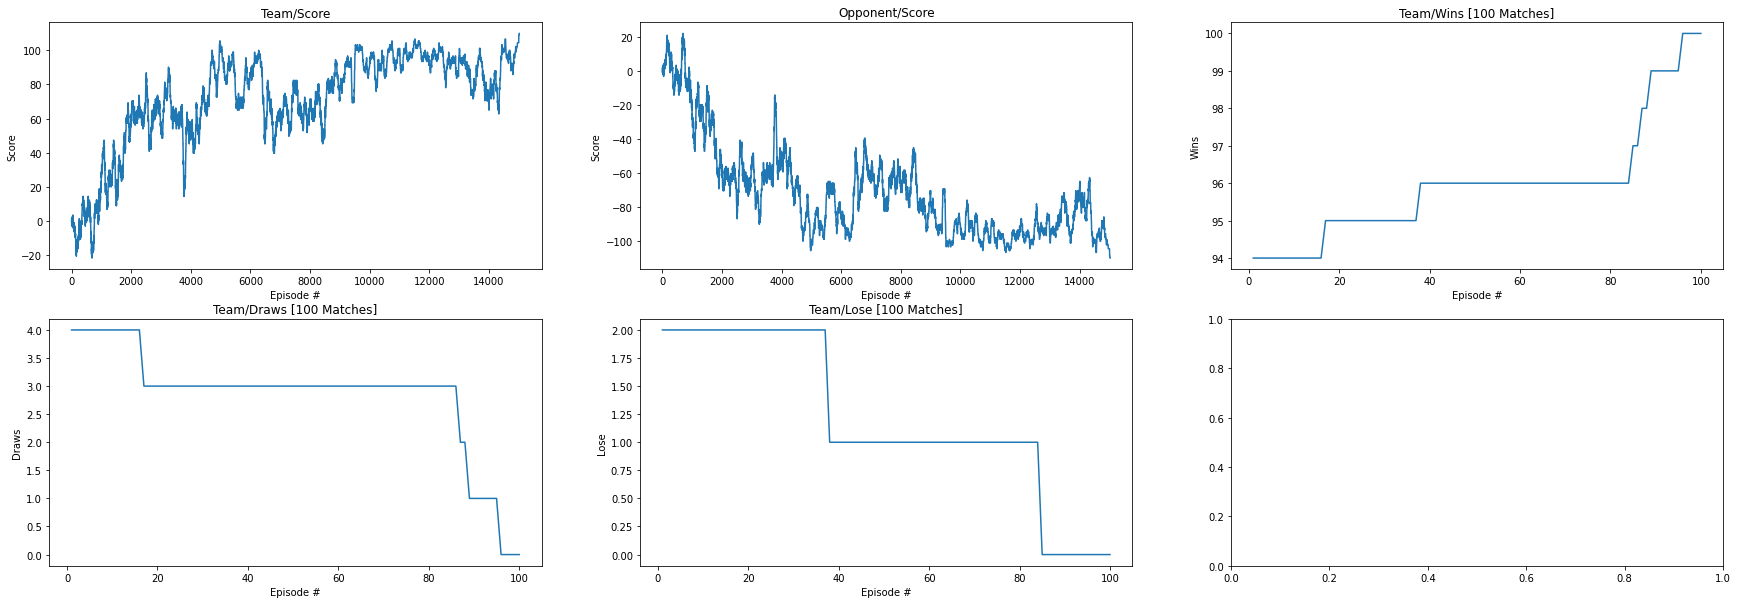

===== Goalie =====


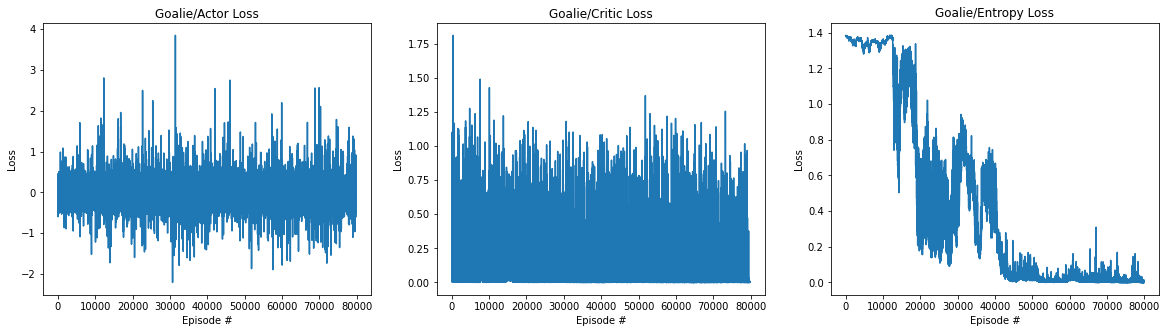

===== Striker =====


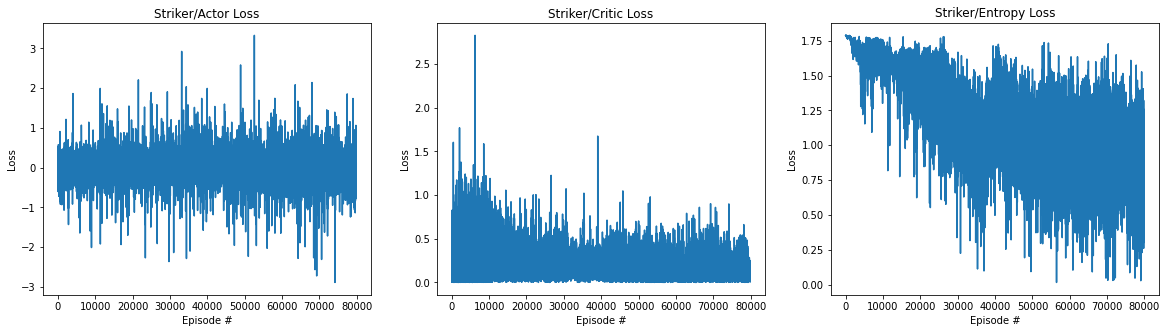

In [18]:
# Decided to output entropy loss instead for meaningful visualization
team_logger.plot_stats()
g_logger.plot_stats()                       
s_logger.plot_stats()

In [27]:
#######################
# Sample Game w/ RANDOM AGENT (Without GAE)
#######################

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_actor_ep9700.pth'))
g_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_critic_ep9700.pth'))
s_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_actor_ep9700.pth'))
s_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_critic_ep9700.pth'))
total_score = total_score_opp = total_wins = total_lose = total_draws = 0
num_episodes = 100
max_t = 2000
print("Playing...")

for i_episode in range(1, num_episodes+1):            # play game for 100 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    
    while True:
    #for t in range(max_t): 
        
        # select actions and send to environment
        g_action, g_log_prob = g_agent.act(g_states[0])
        s_action, s_log_prob = s_agent.act(s_states[0])
        g_actions = (g_action, np.random.randint(g_action_size))
        s_actions = (s_action, np.random.randint(s_action_size))
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
        env_info = env.step(actions)                            
        
        # get next states, rewards & dones
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        done = np.any(env_info[g_brain_name].local_done) 
        
        # Store in experience buffer & learn
        all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
        #g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
        #s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
        g_states = g_next_states
        s_states = s_next_states
        g_scores += g_rewards
        s_scores += s_rewards   
        
        # Cache scores for display
        team_score = g_rewards[0] + s_rewards[0]
        opp_score = g_rewards[1] + s_rewards[1]
        total_score += (team_score)
        total_score_opp += (opp_score)
        
        if done: 
            break
    
    total_wins += int(1 if team_score > opp_score else 0)
    total_draws += int(1 if team_score == opp_score else 0)
    total_lose += int(1 if team_score < opp_score else 0)
        
    print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
          .format(i_episode, total_score, total_score_opp, total_wins, 
                  total_lose, total_draws, i_episode))

Playing...
Episode 1: 	Team Score: 1.10 	Opponent Score: -1.10 	 Win|Lose|Draw: 1|0|0 	 [Out of 1 Matches]
Episode 2: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 2|0|0 	 [Out of 2 Matches]
Episode 3: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 3|0|0 	 [Out of 3 Matches]
Episode 4: 	Team Score: 4.40 	Opponent Score: -4.40 	 Win|Lose|Draw: 4|0|0 	 [Out of 4 Matches]
Episode 5: 	Team Score: 5.50 	Opponent Score: -5.50 	 Win|Lose|Draw: 5|0|0 	 [Out of 5 Matches]
Episode 6: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 6|0|0 	 [Out of 6 Matches]
Episode 7: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 7|0|0 	 [Out of 7 Matches]
Episode 8: 	Team Score: 8.80 	Opponent Score: -8.80 	 Win|Lose|Draw: 8|0|0 	 [Out of 8 Matches]
Episode 9: 	Team Score: 9.90 	Opponent Score: -9.90 	 Win|Lose|Draw: 9|0|0 	 [Out of 9 Matches]
Episode 10: 	Team Score: 11.00 	Opponent Score: -11.00 	 Win|Lose|Draw: 10|0|0 	 [Out of 10 Matches]
Episode 11: 	Team Score:

Episode 83: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 79|3|1 	 [Out of 83 Matches]
Episode 84: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 80|3|1 	 [Out of 84 Matches]
Episode 85: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 81|3|1 	 [Out of 85 Matches]
Episode 86: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 82|3|1 	 [Out of 86 Matches]
Episode 87: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 83|3|1 	 [Out of 87 Matches]
Episode 88: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 84|3|1 	 [Out of 88 Matches]
Episode 89: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 85|3|1 	 [Out of 89 Matches]
Episode 90: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 85|3|2 	 [Out of 90 Matches]
Episode 91: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 86|3|2 	 [Out of 91 Matches]
Episode 92: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|2 	 [Out of 92

In [19]:
#######################
# Sample Game w/ RANDOM AGENT (With GAE)
#######################

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_actor_ep15020.pth'))
g_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_critic_ep15020.pth'))
s_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_actor_ep15020.pth'))
s_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_critic_ep15020.pth'))
total_score = total_score_opp = total_wins = total_lose = total_draws = 0
num_episodes = 100
max_t = 2000
print("Playing...")

for i_episode in range(1, num_episodes+1):            # play game for 100 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    
    while True:
    #for t in range(max_t): 
        
        # select actions and send to environment
        g_action, g_log_prob = g_agent.act(g_states[0])
        s_action, s_log_prob = s_agent.act(s_states[0])
        g_actions = (g_action, np.random.randint(g_action_size))
        s_actions = (s_action, np.random.randint(s_action_size))
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
        env_info = env.step(actions)                            
        
        # get next states, rewards & dones
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        done = np.any(env_info[g_brain_name].local_done) 
        
        # Store in experience buffer & learn
        all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
        #g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
        #s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
        g_states = g_next_states
        s_states = s_next_states
        g_scores += g_rewards
        s_scores += s_rewards   
        
        # Cache scores for display
        team_score = g_rewards[0] + s_rewards[0]
        opp_score = g_rewards[1] + s_rewards[1]
        total_score += (team_score)
        total_score_opp += (opp_score)
        
        if done: 
            break
    
    total_wins += int(1 if team_score > opp_score else 0)
    total_draws += int(1 if team_score == opp_score else 0)
    total_lose += int(1 if team_score < opp_score else 0)
        
    print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
          .format(i_episode, total_score, total_score_opp, total_wins, 
                  total_lose, total_draws, i_episode))

Playing...
Episode 1: 	Team Score: 1.10 	Opponent Score: -1.10 	 Win|Lose|Draw: 1|0|0 	 [Out of 1 Matches]
Episode 2: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 2|0|0 	 [Out of 2 Matches]
Episode 3: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 3|0|0 	 [Out of 3 Matches]
Episode 4: 	Team Score: 4.40 	Opponent Score: -4.40 	 Win|Lose|Draw: 4|0|0 	 [Out of 4 Matches]
Episode 5: 	Team Score: 5.50 	Opponent Score: -5.50 	 Win|Lose|Draw: 5|0|0 	 [Out of 5 Matches]
Episode 6: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 6|0|0 	 [Out of 6 Matches]
Episode 7: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 7|0|0 	 [Out of 7 Matches]
Episode 8: 	Team Score: 8.80 	Opponent Score: -8.80 	 Win|Lose|Draw: 8|0|0 	 [Out of 8 Matches]
Episode 9: 	Team Score: 9.90 	Opponent Score: -9.90 	 Win|Lose|Draw: 9|0|0 	 [Out of 9 Matches]
Episode 10: 	Team Score: 11.00 	Opponent Score: -11.00 	 Win|Lose|Draw: 10|0|0 	 [Out of 10 Matches]
Episode 11: 	Team Score:

Episode 83: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 80|2|1 	 [Out of 83 Matches]
Episode 84: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 81|2|1 	 [Out of 84 Matches]
Episode 85: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 82|2|1 	 [Out of 85 Matches]
Episode 86: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|2|1 	 [Out of 86 Matches]
Episode 87: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 84|2|1 	 [Out of 87 Matches]
Episode 88: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 85|2|1 	 [Out of 88 Matches]
Episode 89: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 86|2|1 	 [Out of 89 Matches]
Episode 90: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 87|2|1 	 [Out of 90 Matches]
Episode 91: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 88|2|1 	 [Out of 91 Matches]
Episode 92: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 89|2|1 	 [Out of 92

In [42]:
#######################
# Sample Game w/ SIMILAR AGENT (Without GAE)
# Observation: Lots of potential to learn by playing against each other... MA-PPO?
#######################

g1_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s1_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g1_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_actor_ep9700.pth'))
g1_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_critic_ep9700.pth'))
s1_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_actor_ep9700.pth'))
s1_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_critic_ep9700.pth'))

g2_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s2_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g2_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_actor_ep9700.pth'))
g2_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/goalie/checkpoint_critic_ep9700.pth'))
s2_agent.actor_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_actor_ep9700.pth'))
s2_agent.critic_net.load_state_dict(torch.load('weights/saved/without_gae/striker/checkpoint_critic_ep9700.pth'))

total_score = total_score_opp = total_wins = total_lose = total_draws = 0
num_episodes = 100
max_t = 2000
print("Playing...")

for i_episode in range(1, num_episodes+1):            # play game for 100 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    
    while True:
    #for t in range(max_t): 
        
        # select actions and send to environment
        g1_action, g1_log_prob = g1_agent.act(g_states[0])
        s1_action, s1_log_prob = s1_agent.act(s_states[0])
        g2_action, g2_log_prob = g2_agent.act(g_states[1])
        s2_action, s2_log_prob = s2_agent.act(s_states[1])
        g_actions = (g1_action, g2_action)
        s_actions = (s1_action, s2_action)
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
        env_info = env.step(actions)                            
        
        # get next states, rewards & dones
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        done = np.any(env_info[g_brain_name].local_done) 
        
        # Store in experience buffer & learn
        all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
        #g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
        #s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
        g_states = g_next_states
        s_states = s_next_states
        g_scores += g_rewards
        s_scores += s_rewards   
        
        # Cache scores for display
        team_score = g_rewards[0] + s_rewards[0]
        opp_score = g_rewards[1] + s_rewards[1]
        total_score += (team_score)
        total_score_opp += (opp_score)
        
        if done: 
            break
    
    total_wins += int(1 if team_score > opp_score else 0)
    total_draws += int(1 if team_score == opp_score else 0)
    total_lose += int(1 if team_score < opp_score else 0)
        
    print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
          .format(i_episode, total_score, total_score_opp, total_wins, 
                  total_lose, total_draws, i_episode))

Playing...
Episode 1: 	Team Score: 1.10 	Opponent Score: -1.10 	 Win|Lose|Draw: 1|0|0 	 [Out of 1 Matches]
Episode 2: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 2|0|0 	 [Out of 2 Matches]
Episode 3: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 3|0|0 	 [Out of 3 Matches]
Episode 4: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 3|1|0 	 [Out of 4 Matches]
Episode 5: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 4|1|0 	 [Out of 5 Matches]
Episode 6: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 4|2|0 	 [Out of 6 Matches]
Episode 7: 	Team Score: 1.10 	Opponent Score: -1.10 	 Win|Lose|Draw: 4|3|0 	 [Out of 7 Matches]
Episode 8: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 5|3|0 	 [Out of 8 Matches]
Episode 9: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 5|3|1 	 [Out of 9 Matches]
Episode 10: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 6|3|1 	 [Out of 10 Matches]
Episode 11: 	Team Score: 4.

Episode 84: 	Team Score: 5.50 	Opponent Score: -5.50 	 Win|Lose|Draw: 42|37|5 	 [Out of 84 Matches]
Episode 85: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 43|37|5 	 [Out of 85 Matches]
Episode 86: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 44|37|5 	 [Out of 86 Matches]
Episode 87: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 44|38|5 	 [Out of 87 Matches]
Episode 88: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 44|38|6 	 [Out of 88 Matches]
Episode 89: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 45|38|6 	 [Out of 89 Matches]
Episode 90: 	Team Score: 8.80 	Opponent Score: -8.80 	 Win|Lose|Draw: 46|38|6 	 [Out of 90 Matches]
Episode 91: 	Team Score: 9.90 	Opponent Score: -9.90 	 Win|Lose|Draw: 47|38|6 	 [Out of 91 Matches]
Episode 92: 	Team Score: 8.80 	Opponent Score: -8.80 	 Win|Lose|Draw: 47|39|6 	 [Out of 92 Matches]
Episode 93: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 47|40|6 	 [Out of 93 Matches]


In [ ]:
#######################
# Sample Game w/ SIMILAR AGENT (With GAE)
# Observation: Lots of potential to learn by playing against each other... Self-Play?
#######################

g1_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s1_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g1_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_actor_ep11520.pth'))
g1_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_critic_ep11520.pth'))
s1_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_actor_ep11520.pth'))
s1_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_critic_ep11520.pth'))

g2_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s2_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g2_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_actor_ep11520.pth'))
g2_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/goalie/checkpoint_critic_ep11520.pth'))
s2_agent.actor_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_actor_ep11520.pth'))
s2_agent.critic_net.load_state_dict(torch.load('weights/saved/with_gae/striker/checkpoint_critic_ep11520.pth'))

total_score = total_score_opp = total_wins = total_lose = total_draws = 0
num_episodes = 100
max_t = 2000
print("Playing...")

for i_episode in range(1, num_episodes+1):            # play game for 100 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    
    while True:
    #for t in range(max_t): 
        
        # select actions and send to environment
        g1_action, g1_log_prob = g1_agent.act(g_states[0])
        s1_action, s1_log_prob = s1_agent.act(s_states[0])
        g2_action, g2_log_prob = g2_agent.act(g_states[1])
        s2_action, s2_log_prob = s2_agent.act(s_states[1])
        g_actions = (g1_action, g2_action)
        s_actions = (s1_action, s2_action)
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
        env_info = env.step(actions)                            
        
        # get next states, rewards & dones
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        done = np.any(env_info[g_brain_name].local_done) 
        
        # Store in experience buffer & learn
        all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
        #g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
        #s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
        g_states = g_next_states
        s_states = s_next_states
        g_scores += g_rewards
        s_scores += s_rewards   
        
        # Cache scores for display
        team_score = g_rewards[0] + s_rewards[0]
        opp_score = g_rewards[1] + s_rewards[1]
        total_score += (team_score)
        total_score_opp += (opp_score)
        
        if done: 
            break
    
    total_wins += int(1 if team_score > opp_score else 0)
    total_draws += int(1 if team_score == opp_score else 0)
    total_lose += int(1 if team_score < opp_score else 0)
        
    print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
          .format(i_episode, total_score, total_score_opp, total_wins, 
                  total_lose, total_draws, i_episode))

# Training against a Trained Agent (MA-PPO)

In [26]:
def ppo_self_play():
    
    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now()         
    env_info = env.reset(train_mode=True)
    g1_logger.initialize(g1_agent, g_state_size, g_action_size)
    s1_logger.initialize(s1_agent, s_state_size, s_action_size)
    g2_logger.initialize(g2_agent, g_state_size, g_action_size)
    s2_logger.initialize(s2_agent, s_state_size, s_action_size)
    step = 0

    try:
        start_eps = params.eps_to_resume_from if not params.restart_training else 1        
        for i_episode in range(start_eps, params.n_episodes+1):
            env_info = env.reset(train_mode=True)                  # reset the environment
            g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
            s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)            
            g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
            s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
            num_steps = 0

            for t in range(params.max_t):    
                num_steps = t

                # Perform actions from each agent's policy network (clipped actions [0, -1])
                g1_action, g1_log_prob = g1_agent.act(g_states[0])
                s1_action, s1_log_prob = s1_agent.act(s_states[0])
                g2_action, g2_log_prob = g2_agent.act(g_states[1])
                s2_action, s2_log_prob = s2_agent.act(s_states[1])
                g_actions = (g1_action, g2_action)
                s_actions = (s1_action, s2_action)
                actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
                env_info = env.step(actions)                   

                # get next states, rewards & dones
                g_next_states = env_info[g_brain_name].vector_observations         
                s_next_states = env_info[s_brain_name].vector_observations
                g_rewards = env_info[g_brain_name].rewards  
                s_rewards = env_info[s_brain_name].rewards
                done = np.any(env_info[g_brain_name].local_done) 

                # Store in experience buffer & learn
                all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
                g1_agent.step(g_states[0], all_states, g1_action, g_rewards[0], g1_log_prob, done)
                s1_agent.step(s_states[0], all_states, s1_action, s_rewards[0], s1_log_prob, done)
                g2_agent.step(g_states[1], all_states, g2_action, g_rewards[1], g2_log_prob, done)
                s2_agent.step(s_states[1], all_states, s2_action, s_rewards[1], s2_log_prob, done)
                g_states = g_next_states
                s_states = s_next_states
                g_scores += g_rewards
                s_scores += s_rewards                

                # Break if game is over (time out / score)
                if done:   
                    break 

            # Learn from episode
            last_all_states = np.concatenate((s_next_states[0], s_next_states[1], g_next_states[0], g_next_states[1]))  
            g1_agent.add_last_all_state(last_all_states)
            s1_agent.add_last_all_state(last_all_states)
            g2_agent.add_last_all_state(last_all_states)
            s2_agent.add_last_all_state(last_all_states)
            g1_agent.learn()
            s1_agent.learn()
            g2_agent.learn()
            s2_agent.learn()

            # Print crucial results for progress tracking
            for i in range(len(g1_agent.actor_losses)):
                step += 1
                g1_logger.log_stats(step, g_scores[0], g1_agent.actor_losses[i], g1_agent.critic_losses[i], g1_agent.entropy_losses[i])
                s1_logger.log_stats(step, s_scores[0], s1_agent.actor_losses[i], s1_agent.critic_losses[i], s1_agent.entropy_losses[i])
                g2_logger.log_stats(step, g_scores[1], g2_agent.actor_losses[i], g2_agent.critic_losses[i], g2_agent.entropy_losses[i])
                s2_logger.log_stats(step, s_scores[1], s2_agent.actor_losses[i], s2_agent.critic_losses[i], s2_agent.entropy_losses[i])
            team1_logger.log_stats(i_episode, g_scores[0] + s_scores[0], g_scores[1] + s_scores[1])
            team2_logger.log_stats(i_episode, g_scores[1] + s_scores[1], g_scores[0] + s_scores[0])
            print('\rEpisode {}: \tNum Steps: {} \t G_score: {:.2f} \t S_Score: {:.2f}  \tWin: {} \t\t'.format(i_episode, num_steps, g1_logger.scores_deque[-1], 
                                                            s1_logger.scores_deque[-1], team1_logger.wins_deque[-1]), end="")

            if i_episode % params.save_every == 0:
                s1_logger.save_weights(i_episode)
                g1_logger.save_weights(i_episode)
                s2_logger.save_weights(i_episode)
                g2_logger.save_weights(i_episode)

            if i_episode % params.print_every == 0:
                print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
                      .format(i_episode, team1_logger.scores_cum_deque[-1], team1_logger.scores_opp_cum_deque[-1], np.count_nonzero(team1_logger.wins_deque), 
                              np.count_nonzero(team1_logger.lose_deque), np.count_nonzero(team1_logger.draws_deque), len(team1_logger.wins_deque)))

                if team1_logger.scores_cum_deque[-1] >= params.target_score:
                    print('\nEnvironment solved in {:d} episodes!\tAvg Total Score: {:.2f} \tAvg Total Wins: {}/{}'
                          .format(i_episode, np.mean(team1_logger.scores_deque), np.count_nonzero(team1_logger.wins_deque), len(team1_logger.wins_deque)))
                    if params.terminate_on_target_score:
                        break

        # Plot graphs & save final weights
        g1_logger.save_weights(i_episode)
        s1_logger.save_weights(i_episode)
        g2_logger.save_weights(i_episode)
        s2_logger.save_weights(i_episode)
        if params.plot_stats:
            team1_logger.plot_stats()
            g1_logger.plot_stats()                       
            s1_logger.plot_stats()
            g2_logger.plot_stats()                       
            s2_logger.plot_stats()
        team1_logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    # Catch any exceptions (Esp with keyboard interrupts)
    except BaseException as error:
        print('\n\n==== An exception occurred: {}'.format(error))
        g1_logger.save_weights(i_episode)
        s1_logger.save_weights(i_episode)
        g2_logger.save_weights(i_episode)
        s2_logger.save_weights(i_episode)
        if params.plot_stats:
            team1_logger.plot_stats()
            team2_logger.plot_stats()
            g1_logger.plot_stats()                       
            s1_logger.plot_stats()
            g2_logger.plot_stats()                       
            s2_logger.plot_stats()
        team1_logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return s_logger.scores_list

In [ ]:
##################
# MA-PPO Training... (From pre-trained weights)
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=20000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 1000
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32
params.beta_decay = 0.9975   # Instead of 0.995
params.restart_training = False
params.eps_to_resume_from = 1

# Goalie1 Params
g1_params = copy.deepcopy(params)
g1_params.lr = 8e-5  
g1_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play_pretrained/goalie1'
g1_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play_pretrained/goalie1'
g1_params.actor_weights_filename_to_resume = 'checkpoint_actor_ep9700_start.pth'
g1_params.critic_weights_filename_to_resume = 'checkpoint_critic_ep9700_start.pth'

# Goalie2 Params
g2_params = copy.deepcopy(params)
g2_params.lr = 8e-5  
g2_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play_pretrained/goalie2'
g2_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play_pretrained/goalie2'
g2_params.actor_weights_filename_to_resume = 'checkpoint_actor_ep9700_start.pth'
g2_params.critic_weights_filename_to_resume = 'checkpoint_critic_ep9700_start.pth'

# Striker1 Params
s1_params = copy.deepcopy(params)
s1_params.lr = 1e-4  
s1_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play_pretrained/striker1'
s1_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play_pretrained/striker1'
s1_params.actor_weights_filename_to_resume = 'checkpoint_actor_ep9700_start.pth'
s1_params.critic_weights_filename_to_resume = 'checkpoint_critic_ep9700_start.pth'

# Striker2 Params
s2_params = copy.deepcopy(params)
s2_params.lr = 1e-4  
s2_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play_pretrained/striker2'
s2_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play_pretrained/striker2'
s2_params.actor_weights_filename_to_resume = 'checkpoint_actor_ep9700_start.pth'
s2_params.critic_weights_filename_to_resume = 'checkpoint_critic_ep9700_start.pth'

# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g1_logger = Logger(g1_params, tb, "Goalie1")
s1_logger = Logger(s1_params, tb, "Striker1")
g2_logger = Logger(g2_params, tb, "Goalie2")
s2_logger = Logger(s2_params, tb, "Striker2")
team1_logger = Logger_Team(params, tb, "Team1")
team2_logger = Logger_Team(params, tb, "Team2")
total_state_size = 2*g_state_size + 2*s_state_size

g1_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g1_params)
s1_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s1_params)
g2_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g2_params)
s2_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s2_params)
g1_agent.print_init_messages()
ppo_self_play()

In [9]:
##################
# MA-PPO Training... (No Pre-train)
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=10000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 1000
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 128      # Increase batch size to avert non-stationary problem (orig: 32)
params.eps = 0.05            # Decrease batch size to avert non-stationary problem (orig: 0.1)
params.beta_decay = 0.999    # (orig: 0.995)
params.restart_training = True
params.eps_to_resume_from = 1

# Goalie1 Params
g1_params = copy.deepcopy(params)
g1_params.lr = 8e-5  
g1_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play/goalie1'
g1_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play/goalie1'

# Goalie2 Params
g2_params = copy.deepcopy(params)
g2_params.lr = 8e-5  
g2_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play/goalie2'
g2_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play/goalie2'

# Striker1 Params
s1_params = copy.deepcopy(params)
s1_params.lr = 1e-4  
s1_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play/striker1'
s1_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play/striker1'

# Striker2 Params
s2_params = copy.deepcopy(params)
s2_params.lr = 1e-4  
s2_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/self_play/striker2'
s2_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/self_play/striker2'

# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g1_logger = Logger(g1_params, tb, "Goalie1")
s1_logger = Logger(s1_params, tb, "Striker1")
g2_logger = Logger(g2_params, tb, "Goalie2")
s2_logger = Logger(s2_params, tb, "Striker2")
team1_logger = Logger_Team(params, tb, "Team1")
team2_logger = Logger_Team(params, tb, "Team2")
total_state_size = 2*g_state_size + 2*s_state_size

g1_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g1_params)
s1_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s1_params)
g2_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=g2_params)
s2_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=s2_params)
g1_agent.print_init_messages()
ppo_self_play()


============ Goalie1 HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.999
BETA_MIN:  5e-05
EPS:  0.05
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker1 HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.999
BETA_MIN:  5e-05
EPS:  0.05
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Goalie2 HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.999
BETA_MIN:  5e-05
EPS:  0.05
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker2 HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_

Episode 2760: 	Team Score: -60.50 	Opponent Score: 60.50 	 Win|Lose|Draw: 9|64|27 	 [Out of 100 Matches]
Episode 2780: 	Team Score: -52.80 	Opponent Score: 52.80 	 Win|Lose|Draw: 12|60|28 	 [Out of 100 Matches]
Episode 2800: 	Team Score: -50.60 	Opponent Score: 50.60 	 Win|Lose|Draw: 13|59|28 	 [Out of 100 Matches]
Episode 2820: 	Team Score: -56.10 	Opponent Score: 56.10 	 Win|Lose|Draw: 11|62|27 	 [Out of 100 Matches]
Episode 2840: 	Team Score: -51.70 	Opponent Score: 51.70 	 Win|Lose|Draw: 15|62|23 	 [Out of 100 Matches]
Episode 2860: 	Team Score: -38.50 	Opponent Score: 38.50 	 Win|Lose|Draw: 20|55|25 	 [Out of 100 Matches]
Episode 2880: 	Team Score: -40.70 	Opponent Score: 40.70 	 Win|Lose|Draw: 20|57|23 	 [Out of 100 Matches]
Episode 2900: 	Team Score: -38.50 	Opponent Score: 38.50 	 Win|Lose|Draw: 21|56|23 	 [Out of 100 Matches]
Episode 2920: 	Team Score: -33.00 	Opponent Score: 33.00 	 Win|Lose|Draw: 25|55|20 	 [Out of 100 Matches]
Episode 2940: 	Team Score: -29.70 	Opponent Sco

Episode 5860: 	Team Score: -4.40 	Opponent Score: 4.40 	 Win|Lose|Draw: 39|43|18 	 [Out of 100 Matches]
Episode 5880: 	Team Score: -9.90 	Opponent Score: 9.90 	 Win|Lose|Draw: 37|46|17 	 [Out of 100 Matches]
Episode 5900: 	Team Score: -15.40 	Opponent Score: 15.40 	 Win|Lose|Draw: 34|48|18 	 [Out of 100 Matches]
Episode 5920: 	Team Score: -19.80 	Opponent Score: 19.80 	 Win|Lose|Draw: 35|53|12 	 [Out of 100 Matches]
Episode 5940: 	Team Score: -23.10 	Opponent Score: 23.10 	 Win|Lose|Draw: 35|56|9 	 [Out of 100 Matches]
Episode 5960: 	Team Score: -30.80 	Opponent Score: 30.80 	 Win|Lose|Draw: 31|59|10 	 [Out of 100 Matches]
Episode 5980: 	Team Score: -19.80 	Opponent Score: 19.80 	 Win|Lose|Draw: 35|53|12 	 [Out of 100 Matches]
Episode 6000: 	Team Score: -34.10 	Opponent Score: 34.10 	 Win|Lose|Draw: 29|60|11 	 [Out of 100 Matches]
Episode 6020: 	Team Score: -36.30 	Opponent Score: 36.30 	 Win|Lose|Draw: 28|61|11 	 [Out of 100 Matches]
Episode 6040: 	Team Score: -29.70 	Opponent Score: 

KeyboardInterrupt: 